In [28]:
import numpy as np
import sys
import os
import glob
import torch

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from demo.lib.preprocess import *
from dwpose.scripts.dwpose import DWposeDetector
from dwpose.scripts.tool import read_frames

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
detector = DWposeDetector(
    det_config="D:\\github\\skating-ai\\v3\\pose\\dwpose\\config\\yolox_l_8xb8-300e_coco.py",
    # det_ckpt = args.yolox_ckpt,
    pose_config="D:\\github\\skating-ai\\v3\\pose\\dwpose\\config\\dwpose-l_384x288.py",
    # pose_ckpt = args.dwpose_ckpt,
    keypoints_only=True,
)
detector = detector.to(device)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_l_8x8_300e_coco/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
Loads checkpoint by http backend from path: https://huggingface.co/wanghaofan/dw-ll_ucoco_384/resolve/main/dw-ll_ucoco_384.pth


In [30]:
video_paths = glob.glob("D:\\github\\FS-Jump3D\\data\\**\\*.mp4", recursive=True)
video_path = video_paths[0]
frame = read_frames(video_path)[-100]
kpts2d = []
score2d = []

person_idx = 0

pose = detector(frame)
candidate = pose["bodies"]["candidate"]
subset = pose["bodies"]["subset"]
num_person = subset.shape[0]
num_joints = subset.shape[1]
keypoint = candidate.reshape(num_person, num_joints, 2)

kpt, score = coco_coco(keypoint[0], subset[0])
kpts2d.append(kpt)
score2d.append(score)

c:\Users\user\dev\Python\Python311\Lib\site-packages\mmdet\models\backbones\csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
c:\Users\user\dev\Python\Python311\Lib\site-packages\mmdet\models\layers\se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [31]:
kpts2d = np.expand_dims(np.array(kpts2d), axis=1)
score2d = np.expand_dims(np.array(score2d), axis=1)

kpts2d, score2d, _ = h36m_coco_format(kpts2d, score2d)
kpts2d = kpts2d.squeeze(axis=1)
score2d = score2d.squeeze(axis=1)

In [32]:
kpts2d.shape

(1, 17, 2)

In [34]:
connections = [
    (10, 9),
    (9, 8),
    (8, 11),
    (8, 14),
    (14, 15),
    (15, 16),
    (11, 12),
    (12, 13),
    (8, 7),
    (7, 0),
    (0, 4),
    (0, 1),
    (1, 2),
    (2, 3),
    (4, 5),
    (5, 6),
]

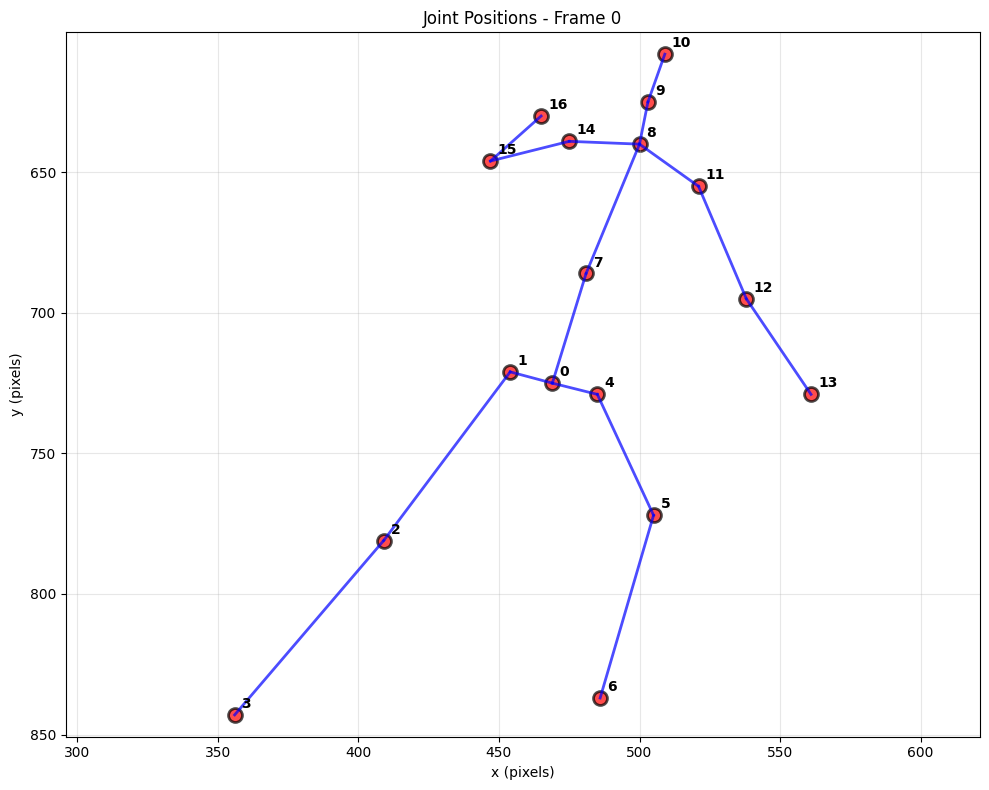

In [38]:
import matplotlib.pyplot as plt
import numpy as np

frame_idx = 0
single_frame = kpts2d[0]

image_width = 1920
image_height = 1080

plt.figure(figsize=(10, 8))

x_coords = (single_frame[:, 0] * image_width).astype(int)
y_coords = (single_frame[:, 1] * image_height).astype(int)

for connection in connections:
    joint1, joint2 = connection
    x_vals = [x_coords[joint1], x_coords[joint2]]
    y_vals = [y_coords[joint1], y_coords[joint2]]
    plt.plot(x_vals, y_vals, "b-", linewidth=2, alpha=0.7)

plt.scatter(
    x_coords, y_coords, c="red", s=100, alpha=0.7, edgecolors="black", linewidth=2
)

for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    plt.annotate(
        f"{i}",
        (x, y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
    )

plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.title(f"Joint Positions - Frame {frame_idx}")
plt.grid(True, alpha=0.3)

# Key change: Invert Y-axis to match image coordinates (origin at top-left)
plt.gca().invert_yaxis()

plt.axis("equal")
plt.tight_layout()
plt.show()